In [1]:
#All imports
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

In [2]:
#set seed value for reproducibility
seed_val=42

tf.random.set_seed(seed_val)

**Data Reading and Understanding**

In [3]:
#Read data
train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [5]:
#Check if any null pixel value
null_count = train_df.isnull().sum()
null_count[null_count.values > 0].index

Index([], dtype='object')

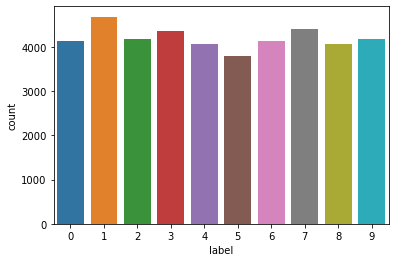

In [6]:
#check distribution of samples for each label(i.e digit 0-9)
sns.countplot(train_df['label'])
plt.show()

**Number of samples for each digit are close in count**

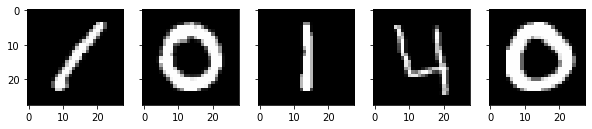

In [7]:
#display few images from train dataset
fig, ax = plt.subplots(1,5, sharey=True, figsize=(10,6))

for i in range(5):  
  img = np.array(train_df.iloc[i, 1:])
  ax[i].imshow(img.reshape(28,28), cmap='gray')

**Data Preprocessing**

In [8]:
IMG_SHAPE =28
BATCH_SZ=64

In [9]:
X = train_df.iloc[:,1:]
y = train_df.iloc[:,0]

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=100)

In [10]:
#scale the images to bring pixel values in 0-1 range
def preprocess_img(img):
  img = np.array(img, dtype=np.float32)
  img = img.reshape(IMG_SHAPE, IMG_SHAPE)
  img = img/255  
  img = img[:,:,np.newaxis]
  return img

In [11]:
#Convert datasets to rank 4 dimension(#ofsamples, height, width, depth)
X_train = X_train.apply(lambda x:preprocess_img(x), axis=1)
X_val = X_val.apply(lambda x:preprocess_img(x), axis=1)

X_train = np.stack(X_train)
X_val = np.stack(X_val)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)

**Modelling**

In [12]:
#Define CNN
model = tf.keras.models.Sequential([
          tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 1)),
          tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
          
          tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
          tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
          
          tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
          tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
          
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dropout(0.2),

          tf.keras.layers.Dense(512, activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(10, activation='softmax')
        ])

model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [13]:
#stop iterations if model does not show any improvement for 50 consecutive epochs
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=50, mode='max')

model.fit(X_train,y_train,       
          steps_per_epoch=np.ceil(len(X_train)/BATCH_SZ),
          epochs=100,
          validation_data=(X_val, y_val),
          validation_steps = np.ceil(len(X_val)/BATCH_SZ),
          callbacks = [model_checkpoint, early_stopping]          
          )

Epoch 1/100
525/525 [==============================] - 16s 30ms/step - loss: 0.6348 - accuracy: 0.7933 - val_loss: 0.0925 - val_accuracy: 0.9712

Epoch 00001: val_accuracy improved from -inf to 0.97119, saving model to best_model.h5
Epoch 2/100
525/525 [==============================] - 15s 29ms/step - loss: 0.0831 - accuracy: 0.9734 - val_loss: 0.0577 - val_accuracy: 0.9814

Epoch 00002: val_accuracy improved from 0.97119 to 0.98143, saving model to best_model.h5
Epoch 3/100
525/525 [==============================] - 15s 29ms/step - loss: 0.0581 - accuracy: 0.9806 - val_loss: 0.0484 - val_accuracy: 0.9851

Epoch 00003: val_accuracy improved from 0.98143 to 0.98512, saving model to best_model.h5
Epoch 4/100
525/525 [==============================] - 16s 30ms/step - loss: 0.0427 - accuracy: 0.9860 - val_loss: 0.0503 - val_accuracy: 0.9846

Epoch 00004: val_accuracy did not improve from 0.98512
Epoch 5/100
525/525 [==============================] - 15s 29ms/step - loss: 0.0374 - accuracy

**Fetch the saved best model**

In [14]:
final_model = tf.keras.models.load_model('./best_model.h5')

**Prediction on test set**

In [15]:
X_test = test_df.apply(lambda x:preprocess_img(x), axis=1)
X_test = np.stack(X_test)

predictions = final_model.predict(X_test)
test_predictions = np.argmax(predictions, axis=1)

In [16]:
submission = pd.DataFrame({'ImageId':test_df.index.values+1, 'Label':test_predictions})
submission.to_csv('./submission.csv', index=False)